In [1]:
import json
import itertools
import re
import os
import pandas as pd

In [2]:
with open('data/ios_signatures.json', encoding='utf-8') as fh:
    signatures = json.load(fh)
    
with open('data_processed/ios_trackers.json', encoding='utf-8') as fh:
    trackers = json.load(fh)

In [3]:
apps = {}
for app, v in trackers.items():
    entry = {}
    
    for signature in signatures:
        if signature['id'] in v:
            entry[signature['name']] = True

    apps[app] = entry

apps = pd.DataFrame.from_dict(apps, orient='index').fillna(False)
nontrackers = [
    "Alipay",
    "Tencent Login",
    "Twitter Account Kit",
    "Google Firebase",
    "Get device information",
    "AdID access",
    "Google Firebase Messaging",
    "Google Consent API",
    "YouTube",
    "Google Sign-In",
    "Google Maps",
    "Amazon AWS",
    "iAd"
]

# only include top trackers
included_trackers = [
    "Google AdMob",
    "Facebook",
    "Facebook Ads",
    "Facebook Analytics",
    "Google CrashLytics",
    "Google Analytics",
    "Inmobi",
    "Unity3d Ads",
    "Moat",
    "Twitter MoPub",
    "AppLovin (MAX and SparkLabs)",
    "ChartBoost",
    "AdColony",
    "Amazon Analytics (Amazon insights)",
    "HockeyApp",
    "Tapjoy",
    "Branch",
    "Microsoft Visual Studio App Center",            # iOS
    "Microsoft Visual Studio App Center Crashes",    # Android
    "Microsoft Visual Studio App Center Analytics",  # Android
    "Adobe Experience Cloud",
    "MixPanel",
    "Adjust",
    "Amplitude",
    "Heyzap (bought by Fyber)",
    "Amazon Advertisement",
    "Vungle",
    "AppsFlyer",
    #"WeChat",          # iOS
    "Baidu",           # iOS + Android
    #"Baidu APPX",
    #"Baidu Location",
    #"Baidu Map",
    #"Baidu Mobile Ads",
    #"Baidu Mobile Stat",
    #"Baidu Navigation",
    "Umeng+",           # iOS + Android
    #"Umeng Analytics",
    #"Umeng Feedback",
    "JiGuang Aurora Mobile JPush",
    "Tencent",
    "Tencent Ads",
    "Tencent MTA",
    "Bugly",
    #"Tencent Map LBS",
    "WeChat Location",
    "ironSource",
    "Startapp",
    "Google Tag Manager",
    "Pollfish",
    "Nexage",
    "Flurry",
    "Verizon Ads",
    "Revmob",
    "New Relic",
    "Supersonic Ads",
    "Appodeal",
    "Fyber",
    "Smaato",
    "Urbanairship",
    "MobFox",
    "Localytics",
    "Appcelerator Analytics",
    "AdBuddiz",
    "Radius Networks",
    "ComScore",
    "Soomla",
    "BugSense",
    "Yandex Ad",
    "Mail.ru",
    "Quantcast",
    "VKontakte SDK",
    "Batch",
    "Tapdaq",
    "Fyber SponsorPay",
    "Ooyala",
    "Google Firebase Analytics",
    "AdTech Mobile SDK",
    "PlayHaven",
    #"WeiboSDK",
    #"Weibo",
    "AppMetrica",
    "Mintegral",
    #"Ogury Presage",
    #"Appnext",
    "myTarget",
    "CleverTap",
    #"Sensors Analytics",
    "Braze (formerly Appboy)",
    "Bugsnag",
    "Kochava",
    "Pangle",
    "SKAdNetwork",
    "Google Play Services"
]

apps_nontrackers = apps[[col for col in apps if col not in included_trackers]]
apps_trackers = apps[[col for col in apps if col in included_trackers]]
apps_trackers = apps_trackers.rename({'WeiboSDK': 'Weibo'}, axis = 1)

apps_trackers["Tencent"] = apps_trackers["Tencent Ads"] | apps_trackers["Tencent MTA"]
apps_trackers = apps_trackers.drop(['Tencent Ads', 'Tencent MTA'], axis = 1)

#apps_nontrackers.mean() * 100
apps_trackers.sum().sum() / len(apps) # mean trackers per app

3.187897024406553

In [4]:
apps_trackers.mean().sort_values(ascending=False)[0:20] * 100

SKAdNetwork                     69.600468
Google Firebase Analytics       53.853226
Google CrashLytics              31.812103
Facebook                        25.534938
Google AdMob                    22.826814
Google Analytics                12.704781
Unity3d Ads                      7.288532
Google Tag Manager               7.263457
Flurry                           5.240722
Moat                             5.040120
Twitter MoPub                    4.714142
AppsFlyer                        4.672350
Umeng+                           4.170846
AppLovin (MAX and SparkLabs)     4.103979
Amplitude                        3.560682
Vungle                           3.485456
ChartBoost                       3.443664
Branch                           3.326647
AdColony                         3.243063
Supersonic Ads                   2.674691
dtype: float64

In [5]:
import ast
android = pd.read_csv("data/appsAndroid.csv", index_col = 0, converters={'permissions':ast.literal_eval, 'trackersettings':ast.literal_eval})
android = android[android.index.isin(pd.read_csv('data_processed/android_all_apps.csv').app)]
ios = pd.read_csv("data/appsIos.csv", index_col = 0, converters={'permissions':ast.literal_eval, 'trackersettings':ast.literal_eval})
ios = ios[ios.index.isin(pd.read_csv('data_processed/ios_all_apps.csv').app)]

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

def expand(df,col):
    return df.join(pd.DataFrame(mlb.fit_transform(df.get(col)),
                              columns=mlb.classes_,
                              index=df.index).astype(bool))

#ios = expand(ios, 'trackers')
ios = expand(ios, 'trackersettings')
android = expand(android, 'trackersettings')

In [7]:
android['AdID'].mean().round(3)*100

86.1

In [8]:
(apps_nontrackers.mean() * 100).round(1)

Get device information       99.9
Google Firebase              40.8
AdID access                  42.7
Google Sign-In                8.1
YouTube                      52.6
iAd                          12.9
Google Firebase Messaging    22.2
Amazon AWS                    3.2
WeChat                        5.0
WeiboSDK                      2.2
Tencent Login                 2.9
Twitter Account Kit           2.8
Google Maps                   8.5
Tencent Map LBS               0.4
Alipay                        1.8
Parse                         1.3
Google Consent API            0.8
Sentry                        1.8
Kakao                         0.4
Sensors Analytics             0.2
dtype: float64

In [9]:
(apps_nontrackers['AdID access'] & apps_trackers['AppsFlyer']).sum() / apps_trackers['AppsFlyer'].sum()

0.9946332737030411

In [10]:
(ios.permissions.explode().value_counts() / len(ios) * 100)[0:20].round(1).to_csv('data_processed/ios_top_permissions.csv')
system_permissions = ["android.permission.ACCEPT_HANDOVER","android.permission.ACCESS_BACKGROUND_LOCATION","android.permission.ACCESS_CHECKIN_PROPERTIES","android.permission.ACCESS_COARSE_LOCATION","android.permission.ACCESS_FINE_LOCATION","android.permission.ACCESS_LOCATION_EXTRA_COMMANDS","android.permission.ACCESS_MEDIA_LOCATION","android.permission.ACCESS_NETWORK_STATE","android.permission.ACCESS_NOTIFICATION_POLICY","android.permission.ACCESS_WIFI_STATE","android.permission.ACCOUNT_MANAGER","android.permission.ACTIVITY_RECOGNITION","com.android.voicemail.permission.ADD_VOICEMAIL","android.permission.ANSWER_PHONE_CALLS","android.permission.BATTERY_STATS","android.permission.BIND_ACCESSIBILITY_SERVICE","android.permission.BIND_APPWIDGET","android.permission.BIND_AUTOFILL_SERVICE","android.permission.BIND_CALL_REDIRECTION_SERVICE","android.permission.BIND_CARRIER_MESSAGING_CLIENT_SERVICE","android.permission.BIND_CARRIER_MESSAGING_SERVICE","android.permission.BIND_CARRIER_SERVICES","android.permission.BIND_CHOOSER_TARGET_SERVICE","android.permission.BIND_COMPANION_DEVICE_SERVICE","android.permission.BIND_CONDITION_PROVIDER_SERVICE","android.permission.BIND_CONTROLS","android.permission.BIND_DEVICE_ADMIN","android.permission.BIND_DREAM_SERVICE","android.permission.BIND_INCALL_SERVICE","android.permission.BIND_INPUT_METHOD","android.permission.BIND_MIDI_DEVICE_SERVICE","android.permission.BIND_NFC_SERVICE","android.permission.BIND_NOTIFICATION_LISTENER_SERVICE","android.permission.BIND_PRINT_SERVICE","android.permission.BIND_QUICK_ACCESS_WALLET_SERVICE","android.permission.BIND_QUICK_SETTINGS_TILE","android.permission.BIND_REMOTEVIEWS","android.permission.BIND_SCREENING_SERVICE","android.permission.BIND_TELECOM_CONNECTION_SERVICE","android.permission.BIND_TEXT_SERVICE","android.permission.BIND_TV_INPUT","android.permission.BIND_VISUAL_VOICEMAIL_SERVICE","android.permission.BIND_VOICE_INTERACTION","android.permission.BIND_VPN_SERVICE","android.permission.BIND_VR_LISTENER_SERVICE","android.permission.BIND_WALLPAPER","android.permission.BLUETOOTH","android.permission.BLUETOOTH_ADMIN","android.permission.BLUETOOTH_CONNECT","android.permission.BLUETOOTH_PRIVILEGED","android.permission.BLUETOOTH_SCAN","android.permission.BODY_SENSORS","android.permission.BROADCAST_PACKAGE_REMOVED","android.permission.BROADCAST_SMS","android.permission.BROADCAST_STICKY","android.permission.BROADCAST_WAP_PUSH","android.permission.CALL_COMPANION_APP","android.permission.CALL_PHONE","android.permission.CALL_PRIVILEGED","android.permission.CAMERA","android.permission.CAPTURE_AUDIO_OUTPUT","android.permission.CHANGE_COMPONENT_ENABLED_STATE","android.permission.CHANGE_CONFIGURATION","android.permission.CHANGE_NETWORK_STATE","android.permission.CHANGE_WIFI_MULTICAST_STATE","android.permission.CHANGE_WIFI_STATE","android.permission.CLEAR_APP_CACHE","android.permission.CONTROL_LOCATION_UPDATES","android.permission.DELETE_CACHE_FILES","android.permission.DELETE_PACKAGES","android.permission.DIAGNOSTIC","android.permission.DISABLE_KEYGUARD","android.permission.DUMP","android.permission.EXPAND_STATUS_BAR","android.permission.FACTORY_TEST","android.permission.FOREGROUND_SERVICE","android.permission.GET_ACCOUNTS","android.permission.GET_ACCOUNTS_PRIVILEGED","android.permission.GET_PACKAGE_SIZE","android.permission.GET_TASKS","android.permission.GLOBAL_SEARCH","android.permission.HIDE_OVERLAY_WINDOWS","android.permission.HIGH_SAMPLING_RATE_SENSORS","android.permission.INSTALL_LOCATION_PROVIDER","android.permission.INSTALL_PACKAGES","com.android.launcher.permission.INSTALL_SHORTCUT","android.permission.INSTANT_APP_FOREGROUND_SERVICE","android.permission.INTERACT_ACROSS_PROFILES","android.permission.INTERNET","android.permission.KILL_BACKGROUND_PROCESSES","android.permission.LOADER_USAGE_STATS","android.permission.LOCATION_HARDWARE","android.permission.MANAGE_DOCUMENTS","android.permission.MANAGE_EXTERNAL_STORAGE","android.permission.MANAGE_MEDIA","android.permission.MANAGE_ONGOING_CALLS","android.permission.MANAGE_OWN_CALLS","android.permission.MASTER_CLEAR","android.permission.MEDIA_CONTENT_CONTROL","android.permission.MODIFY_AUDIO_SETTINGS","android.permission.MODIFY_PHONE_STATE","android.permission.MOUNT_FORMAT_FILESYSTEMS","android.permission.MOUNT_UNMOUNT_FILESYSTEMS","android.permission.NFC","android.permission.NFC_PREFERRED_PAYMENT_INFO","android.permission.NFC_TRANSACTION_EVENT","android.permission.PACKAGE_USAGE_STATS","android.permission.PERSISTENT_ACTIVITY","android.permission.PROCESS_OUTGOING_CALLS","android.permission.QUERY_ALL_PACKAGES","android.permission.READ_CALENDAR","android.permission.READ_CALL_LOG","android.permission.READ_CONTACTS","android.permission.READ_EXTERNAL_STORAGE","android.permission.READ_INPUT_STATE","android.permission.READ_LOGS","android.permission.READ_PHONE_NUMBERS","android.permission.READ_PHONE_STATE","android.permission.READ_PRECISE_PHONE_STATE","android.permission.READ_SMS","android.permission.READ_SYNC_SETTINGS","android.permission.READ_SYNC_STATS","com.android.voicemail.permission.READ_VOICEMAIL","android.permission.REBOOT","android.permission.RECEIVE_BOOT_COMPLETED","android.permission.RECEIVE_MMS","android.permission.RECEIVE_SMS","android.permission.RECEIVE_WAP_PUSH","android.permission.RECORD_AUDIO","android.permission.REORDER_TASKS","android.permission.REQUEST_COMPANION_PROFILE_WATCH","android.permission.REQUEST_COMPANION_RUN_IN_BACKGROUND","android.permission.REQUEST_COMPANION_USE_DATA_IN_BACKGROUND","android.permission.REQUEST_DELETE_PACKAGES","android.permission.REQUEST_IGNORE_BATTERY_OPTIMIZATIONS","android.permission.REQUEST_INSTALL_PACKAGES","android.permission.REQUEST_OBSERVE_COMPANION_DEVICE_PRESENCE","android.permission.REQUEST_PASSWORD_COMPLEXITY","android.permission.RESTART_PACKAGES","android.permission.SCHEDULE_EXACT_ALARM","android.permission.SEND_RESPOND_VIA_MESSAGE","android.permission.SEND_SMS","com.android.alarm.permission.SET_ALARM","android.permission.SET_ALWAYS_FINISH","android.permission.SET_ANIMATION_SCALE","android.permission.SET_DEBUG_APP","android.permission.SET_PREFERRED_APPLICATIONS","android.permission.SET_PROCESS_LIMIT","android.permission.SET_TIME","android.permission.SET_TIME_ZONE","android.permission.SET_WALLPAPER","android.permission.SET_WALLPAPER_HINTS","android.permission.SIGNAL_PERSISTENT_PROCESSES","android.permission.SMS_FINANCIAL_TRANSACTIONS","android.permission.START_FOREGROUND_SERVICES_FROM_BACKGROUND","android.permission.START_VIEW_PERMISSION_USAGE","android.permission.STATUS_BAR","android.permission.SYSTEM_ALERT_WINDOW","android.permission.TRANSMIT_IR","com.android.launcher.permission.UNINSTALL_SHORTCUT","android.permission.UPDATE_DEVICE_STATS","android.permission.UPDATE_PACKAGES_WITHOUT_USER_ACTION","android.permission.USE_BIOMETRIC","android.permission.USE_FINGERPRINT","android.permission.USE_FULL_SCREEN_INTENT","android.permission.USE_ICC_AUTH_WITH_DEVICE_IDENTIFIER","android.permission.USE_SIP","android.permission.VIBRATE","android.permission.WAKE_LOCK","android.permission.WRITE_APN_SETTINGS","android.permission.WRITE_CALENDAR","android.permission.WRITE_CALL_LOG","android.permission.WRITE_CONTACTS","android.permission.WRITE_EXTERNAL_STORAGE","android.permission.WRITE_GSERVICES","android.permission.WRITE_SECURE_SETTINGS","android.permission.WRITE_SETTINGS","android.permission.WRITE_SYNC_SETTINGS","com.android.voicemail.permission.WRITE_VOICEMAIL"]
permissions_counts = android.permissions.explode().value_counts()
permissions_counts = (permissions_counts[permissions_counts.index.isin(system_permissions)]/ len(android) * 100).round(1)
permissions_counts.to_csv('data_processed/android_top_permissions.csv')
permissions_counts

android.permission.INTERNET                       98.7
android.permission.ACCESS_NETWORK_STATE           94.5
android.permission.WAKE_LOCK                      70.0
android.permission.WRITE_EXTERNAL_STORAGE         63.3
android.permission.READ_EXTERNAL_STORAGE          41.4
                                                  ... 
android.permission.BIND_NFC_SERVICE                0.0
android.permission.SIGNAL_PERSISTENT_PROCESSES     0.0
android.permission.SEND_RESPOND_VIA_MESSAGE        0.0
android.permission.ACCESS_CHECKIN_PROPERTIES       0.0
android.permission.BIND_REMOTEVIEWS                0.0
Name: permissions, Length: 125, dtype: float64

            Android   iOS
Motion          1.4   8.0
Contacts        6.4  16.1
Bluetooth       8.4  17.2
Calendar        3.2  25.2
Microphone      9.6  26.2
Location       28.0  49.2
Camera         21.2  56.3


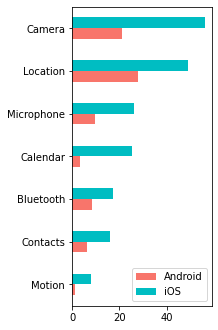

In [11]:
cross_platforms_perms = ['Motion', 'Contacts', 'Bluetooth', 'Calendar', 'Microphone', 'Location', 'Camera']
colors = ['#f8756b', '#00bdc2']
data = pd.DataFrame(
    {
        'Android': android[cross_platforms_perms].mean() * 100,
        'iOS': ios[cross_platforms_perms].mean() * 100
    }
)
ax = data.plot.barh(color=colors, figsize=(2.5,5.5));
ax.figure.savefig('figures/cross-platform-permissions.pdf', bbox_inches='tight');
print(data.round(1))

In [12]:
print(android[android.Calendar].permissions.apply(lambda x: "android.permission.READ_CALENDAR" in x).mean().round(3) * 100)
print(android[android.Calendar].permissions.apply(lambda x: "android.permission.WRITE_CALENDAR" in x).mean().round(3) * 100)
print(android[android.Contacts].permissions.apply(lambda x: "android.permission.READ_CONTACTS" in x).mean().round(3) * 100)
print(android[android.Contacts].permissions.apply(lambda x: "android.permission.WRITE_CONTACTS" in x).mean().round(3) * 100)

95.0
94.5
97.6
47.099999999999994


In [17]:
def android_trackers(app):
    for t in json.loads(app["exodus_analysis"])['trackers']:
        app[t['name']] = True
    
    return app

android_trackers = android[["exodus_analysis"]].apply(android_trackers, axis = 1).fillna(False).drop(["exodus_analysis"], axis = 1)
android_trackers.to_csv('data_processed/android_trackers.json')

In [18]:
android_trackers = pd.read_csv('data_processed/android_trackers.json', index_col="app")
apps_trackers_android = android_trackers[[col for col in android_trackers if col in included_trackers]]
apps_trackers_android['Facebook'] = apps_trackers_android['Facebook Ads'] | apps_trackers_android['Facebook Analytics']
apps_trackers_android["Microsoft Visual Studio App Center"] = apps_trackers_android["Microsoft Visual Studio App Center Crashes"] | apps_trackers_android["Microsoft Visual Studio App Center Analytics"]
apps_trackers_android = apps_trackers_android.drop(['Facebook Ads',
                                                    'Facebook Analytics',
                                                    "Microsoft Visual Studio App Center Crashes",
                                                    "Microsoft Visual Studio App Center Analytics"], axis = 1)

apps_trackers_android = apps_trackers_android[apps_trackers_android.index.isin(android.index)]

apps_trackers_android.mean().sort_values(ascending=False)[0:20] * 100
apps_trackers_android.sum().sum() / len(android_trackers) # trackers mean

<ipython-input-18-4cd0eb6d1f2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps_trackers_android['Facebook'] = apps_trackers_android['Facebook Ads'] | apps_trackers_android['Facebook Analytics']
<ipython-input-18-4cd0eb6d1f2f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps_trackers_android["Microsoft Visual Studio App Center"] = apps_trackers_android["Microsoft Visual Studio App Center Crashes"] | apps_trackers_android["Microsoft Visual Studio App Center Analytics"]


4.01515661839003

In [19]:
android['AdID'].mean().round(3) * 100

86.1

In [20]:
ad_trackers = ['Google AdMob', 'Unity3d Ads', 'Moat', 'Inmobi']
for ad_tracker in ad_trackers:
    print(ad_tracker)
    print(((apps_nontrackers['AdID access'] & apps_trackers[ad_tracker]).sum() / apps_trackers[ad_tracker].sum() * 100).round(1))
    print(((android['AdID'] & apps_trackers_android[ad_tracker]).sum() / apps_trackers_android[ad_tracker].sum() * 100).round(1))

Google AdMob
100.0
99.6
Unity3d Ads
99.9
99.6
Moat
100.0
100.0
Inmobi
94.7
100.0


In [21]:
ad_trackers = ['Google AdMob', 'Unity3d Ads', 'Moat', 'Inmobi']
for ad_tracker in ad_trackers:
    print(ad_tracker)
    print(((apps_nontrackers['AdID access'] & apps_trackers[ad_tracker]).sum() / apps_nontrackers['AdID access'].sum() * 100).round(1))
    print(((android['AdID'] & apps_trackers_android[ad_tracker]).sum() / android['AdID'].sum() * 100).round(1))

Google AdMob
53.4
71.3
Unity3d Ads
17.0
14.1
Moat
11.8
8.7
Inmobi
4.9
8.6


In [22]:
list(android['trackersettings'].explode().dropna().unique())

['FB_Events_Delayed',
 'Firebase_Analytics_Disabled',
 'Firebase_Messaging_Delayed',
 'FB_ADID_Disabled',
 'Firebase_IDFV_Disabled',
 'GAds_Init_Delayed',
 'Firebase_Analytics_Deactivated',
 'FB_Init_Delayed',
 'Firebase_Analytics_Ads_Disabled']

In [23]:
print(len(apps_trackers_android[apps_trackers_android['Google AdMob'] & android['GAds_Init_Delayed']]) / sum(apps_trackers_android['Google AdMob']) * 100)
print(len(apps_trackers[apps_trackers['Google AdMob'] & ios['GAds_Init_Delayed']]) / sum(apps_trackers['Google AdMob']) * 100)

0.7507507507507507
2.2336140607835957


<ipython-input-23-d8295cbd0a44>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(apps_trackers[apps_trackers['Google AdMob'] & ios['GAds_Init_Delayed']]) / sum(apps_trackers['Google AdMob']) * 100)


In [24]:
settings = ['FB_Events_Delayed','FB_Init_Delayed','FB_ADID_Disabled']

for setting in settings:
    print(setting)
    print(len(apps_trackers_android[apps_trackers_android['Facebook'] & android[setting]]) / sum(apps_trackers_android['Facebook']) * 100)
    print(len(apps_trackers[apps_trackers['Facebook'] & ios[setting]]) / sum(apps_trackers['Facebook']) * 100)

FB_Events_Delayed
2.285027059530968
4.615384615384616
FB_Init_Delayed
0.39085989176187613
0.8837970540098199
FB_ADID_Disabled
0.9621166566446182
3.044189852700491


<ipython-input-24-6c1f973597f8>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(apps_trackers[apps_trackers['Facebook'] & ios[setting]]) / sum(apps_trackers['Facebook']) * 100)


In [25]:
settings = ['Firebase_Analytics_Deactivated',
 'Firebase_IDFV_Disabled',
 'Firebase_Messaging_Delayed',
 'Firebase_Analytics_Disabled',
 'Firebase_Analytics_Ads_Disabled']

for setting in settings:
    print(setting)
    print(len(apps_trackers_android[android['Google Firebase'] & android[setting]]) / sum(android['Google Firebase']) * 100)
    print(len(apps_trackers[ios['Google Firebase'] & ios[setting]]) / sum(ios['Google Firebase']) * 100)

Firebase_Analytics_Deactivated
0.5491585473870682
0.4119214926096438
Firebase_IDFV_Disabled
1.204605845881311
0.0726920281075842
Firebase_Messaging_Delayed
1.2223206377325067
0.48461352071722796
Firebase_Analytics_Disabled
1.9840566873339238
0.5088441967530893
Firebase_Analytics_Ads_Disabled
0.01771479185119575
0.0484613520717228


<ipython-input-25-fd1b71f30248>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(apps_trackers[ios['Google Firebase'] & ios[setting]]) / sum(ios['Google Firebase']) * 100)


In [26]:
merged = pd.concat([apps_trackers.mean().rename('iOS'), apps_trackers_android.mean().rename('Android')], axis=1)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print((merged * 100).max(axis=1).sort_values())

PlayHaven                              0.025075
AdTech Mobile SDK                      0.033681
Fyber SponsorPay                       0.050522
BugSense                               0.075226
Ooyala                                 0.083584
WeChat Location                        0.100301
Mail.ru                                0.134725
Soomla                                 0.142093
Verizon Ads                            0.151566
Batch                                  0.159987
Quantcast                              0.200602
Tapdaq                                 0.202088
Appcelerator Analytics                 0.244190
AdBuddiz                               0.252610
Radius Networks                        0.252610
Revmob                                 0.336814
Braze (formerly Appboy)                0.367770
Appodeal                               0.395756
VKontakte SDK                          0.401204
CleverTap                              0.496800
MobFox                                 0

In [27]:
companies = {
    "Google AdMob": "AdMob",
    "Facebook": "Facebook",
    "Google CrashLytics": "Crashlytics",
    "Google Analytics": "Google Analytics",
    "Inmobi": "InMobi",
    "Unity3d Ads": "Unity Technologies",
    "Moat": "Moat",
    "Twitter MoPub": "MoPub",
    "AppLovin (MAX and SparkLabs)": "AppLovin",
    "ChartBoost": "Chartboost",
    "AdColony": "AdColony",
    "Amazon Analytics (Amazon insights)": "Amazon Analytics",
    "HockeyApp": "Bit Stadium",
    "Tapjoy": "Tapjoy",
    "Branch": "Branch",
    "Microsoft Visual Studio App Center": "App Center",
    "Adobe Experience Cloud": "Adobe Experience Cloud",
    "MixPanel": "Mixpanel",
    "Adjust": "Adjust",
    "Amplitude": "Amplitude",
    "Heyzap (bought by Fyber)": "Heyzap",
    "Amazon Advertisement": "Amazon Advertising",
    "Vungle": "Vungle",
    "AppsFlyer": "AppsFlyer",
    "WeChat": "Tencent",
    "Baidu": "Baidu",
    "Umeng+": "Umeng+",
    "JiGuang Aurora Mobile JPush": "JPush",
    "Tencent MTA": "Tencent",
    "Bugly": "Tencent",
    "Tencent Map LBS": "Tencent",
    "WeChat Location": "Tencent",
    "ironSource": "ironSource",
    "Startapp": "StartApp",
    "Google Tag Manager": "Google Tag Manager",
    "Pollfish": "Pollfish",
    "Nexage": "NEXAGE",
    "Flurry": "Flurry",
    "Verizon Ads": "Verizon Media",
    "Revmob": "RevMob",
    "New Relic": "New Relic",
    "Supersonic Ads": "Supersonic Studios",
    "Appodeal": "Appodeal",
    "Fyber": "Fyber",
    "Smaato": "Smaato",
    "Urbanairship": "Airship",
    "MobFox": "Mobfox",
    "Localytics": "Localytics",
    "Appcelerator Analytics": "Appcelerator",
    "AdBuddiz": "AdBuddiz",
    "Radius Networks": "Radius Networks",
    "ComScore": "comScore",
    "Soomla": "Soomla",
    "BugSense": "BugSense",
    "Yandex Ad": "Yandex",
    "Mail.ru": "Mail.ru",
    "Quantcast": "Quantcast",
    "VKontakte SDK": "VKontakte",
    "Batch": "Batch",
    "Tapdaq": "Tapdaq",
    "Fyber SponsorPay": "Fyber",
    "Ooyala": "Ooyala - Flex Media Platform",
    "Google Firebase Analytics": "Firebase",
    "AdTech Mobile SDK": "AdTech",
    "PlayHaven": "PlayHaven",
    "iAd": "Apple",
    "Weibo": "Weibo",
    "SKAdNetwork": "Apple",
    "CleverTap": "CleverTap",
    "Braze (formerly Appboy)": "Braze",
    "Bugsnag": "Bugsnag",
    "myTarget": "My.com",
    "Tencent": "Tencent",
    "Kochava": "Kochava",
    "Mintegral": "Mintegral",
    "Pangle": "Pangle",
    "AppMetrica": "Yandex",
    "Google Play Services": "Google"
}

In [28]:
iosIds = {}
for appId,dbId in ios.id.items():
    iosIds[appId] = dbId
    
androidIds = {}
for appId,dbId in android.id.items():
    androidIds[appId] = dbId

In [29]:
hosts = []

significant_trackers = merged[(merged * 100).max(axis=1) >= 1].index
significant_cols_android = [col for col in apps_trackers_android if col in significant_trackers]

def host_list_android(app):
    appId = app.name
    for k,v in app.items():
        if v == True:
            hosts.append(str(androidIds[appId]) + ";" + k + ";" + companies[k])

apps_trackers_android[significant_cols_android].apply(host_list_android, axis = 1);
with open('data_processed/android_trackers.csv', 'w', encoding='utf-8') as f:
    f.write("id;hosts;company\n" + "\n".join(hosts))

In [30]:
hosts = []

significant_cols = [col for col in apps_trackers if col in significant_trackers]

def host_list_ios(app):
    appId = app.name
    for k,v in app.items():
        if v == True:
            hosts.append(str(iosIds[appId]) + ";" + k + ";" + companies[k])
    
apps_trackers[significant_cols].apply(host_list_ios, axis = 1);
with open('data_processed/ios_trackers.csv', 'w', encoding='utf-8') as f:
    f.write("id;hosts;company\n" + "\n".join(hosts))

## Comparison of All/Cross-Platform/Kids apps

In [31]:
android_fuzzy = android[android.index.isin(pd.read_csv('data_processed/android_fuzzy_apps.csv').app)]
ios_fuzzy = ios[ios.index.isin(pd.read_csv('data_processed/ios_fuzzy_apps.csv').app)]

android_kids = android[~android.family_genre.isnull()]
ios_kids = ios[~ios.family_genre.isnull()]

In [32]:
len(android_kids)

370

In [33]:
len(ios_kids)

109

In [34]:
import numpy as np
import copy
import random

p_total = 10000

import statsmodels.stats.api as sms
def conf(a):
    return sms.DescrStatsW(a).tconfint_mean()

def permTest(df1, df2):
    gT = np.abs(np.average(df1[:]) - np.average(df2[:]))
    pV = list(df1[:]) + list(df2[:])

    #Copy pooled distribution:
    pS = np.array(copy.copy(pV))
    #Initialize permutation:
    pD = []
    #Define p (number of permutations):
    # Permutation loop:
    for i in range(0,p_total):
        np.random.shuffle(pS)
        # Compute permuted absolute difference of your two sampled distributions and store it in pD:
        #pD.append(np.abs(np.average(pS[0:int(len(pS)/2)]) - np.average(pS[int(len(pS)/2):])))
        pD.append(np.abs(np.average(pS[0:len(df1)]) - np.average(pS[len(df1)+1:])))

    p_val = len(np.where(pD>=gT)[0])/p_total
    
    if p_val > 0.1:
        return (p_val, conf(df1), conf(df2))
    else:
        return p_val

In [35]:
datasets = [android,android_fuzzy,android_kids,ios,ios_fuzzy,ios_kids]

In [36]:
for df in datasets:
    print(df.permissions.apply(len).mean().round(1))

11.0
14.3
6.9
3.7
4.0
2.7


In [37]:
for df in datasets:
    print(df[cross_platforms_perms].sum(axis=1).mean().round(1))

0.8
1.2
0.2
2.0
2.1
1.4


In [38]:
for df in datasets:
    print(df['Location'].mean().round(3) * 100)

28.000000000000004
41.099999999999994
3.8
49.2
53.1
26.6


In [39]:
for df in datasets[0:3]:
    print(df['AdID'].mean().round(3) * 100)
    
for df in datasets[3:6]:
    print(df.join(apps_nontrackers[['AdID access']])['AdID access'].mean().round(3) * 100)

86.1
84.39999999999999
89.7
42.699999999999996
49.9
50.5


In [40]:
android_adid_shared = pd.read_csv('data_processed/android_ad_id_shared.txt', header=None, names=['app']).app.apply(lambda x: x[12:-4])

In [41]:
ios_adid_shared = pd.read_csv('data_processed/ios_ad_id_shared.txt', header=None, names=['app']).app.apply(lambda x: x[12:-5])

In [42]:
for df in datasets[0:3]:
    print(round(df.index.isin(android_adid_shared).sum() / len(df) * 100, 1))
    
for df in datasets[3:6]:
    print(round(df.index.isin(ios_adid_shared).sum() / len(df) * 100, 1))

55.4
64.3
59.2
30.9
38.3
24.8


In [43]:
pd.Series(android_kids.index).to_csv('data_processed/android_kids_apps.csv')

In [44]:
pd.Series(ios_kids.index).to_csv('data_processed/ios_kids_apps.csv')

## Permutation tests: All v Cross-Platform

In [45]:
all_root_companies = pd.read_csv('results/all_root_companies.csv')
fuzzy_root_companies = pd.read_csv('results/fuzzy_root_companies.csv')
kids_root_companies = pd.read_csv('results/kids_root_companies.csv')

In [46]:
permTest(all_root_companies[all_root_companies.crawl == 'iOS'].num_companies, fuzzy_root_companies[fuzzy_root_companies.crawl == 'iOS'].num_companies)

0.0

In [47]:
permTest(all_root_companies[all_root_companies.crawl == 'Android'].num_companies, fuzzy_root_companies[fuzzy_root_companies.crawl == 'Android'].num_companies)

0.0

In [48]:
permTest(ios.permissions.apply(len), ios_fuzzy.permissions.apply(len))

0.0023

In [49]:
permTest(android.permissions.apply(len), android_fuzzy.permissions.apply(len))

0.0

In [50]:
permTest(ios[cross_platforms_perms].sum(axis=1), ios_fuzzy[cross_platforms_perms].sum(axis=1))

0.0071

In [51]:
permTest(android[cross_platforms_perms].sum(axis=1), android_fuzzy[cross_platforms_perms].sum(axis=1))

0.0

In [52]:
permTest(ios.join(apps_nontrackers[['AdID access']])['AdID access'], ios_fuzzy.join(apps_nontrackers[['AdID access']])['AdID access'])

0.0

In [53]:
permTest(android['AdID'], android_fuzzy['AdID'])

0.0617

In [54]:
permTest(ios.index.isin(ios_adid_shared), ios_fuzzy.index.isin(ios_adid_shared))

0.0

In [55]:
permTest(android.index.isin(android_adid_shared), android_fuzzy.index.isin(android_adid_shared))

0.0

## Permutation tests: All v Kids

In [56]:
permTest(all_root_companies[all_root_companies.crawl == 'iOS'].num_companies, kids_root_companies[kids_root_companies.crawl == 'iOS'].num_companies)

(0.4105,
 (2.5521738256496698, 2.639066562180487),
 (2.052143813283159, 2.755195636258125))

In [57]:
permTest(all_root_companies[all_root_companies.crawl == 'Android'].num_companies, kids_root_companies[kids_root_companies.crawl == 'Android'].num_companies)

0.0114

In [58]:
permTest(ios.permissions.apply(len), ios_kids.permissions.apply(len))

0.0015

In [59]:
permTest(android.permissions.apply(len), android_kids.permissions.apply(len))

0.0

In [60]:
permTest(ios.index.isin(ios_adid_shared), ios_kids.index.isin(ios_adid_shared))

(0.1786,
 (0.30114397412728156, 0.31771259558184584),
 (0.16536998026835054, 0.33004286376834674))

In [61]:
permTest(android.index.isin(android_adid_shared), android_kids.index.isin(android_adid_shared))

(0.1557,
 (0.5447800073730408, 0.562663576325174),
 (0.5415800158562154, 0.6422037679275683))

In [62]:
permTest(ios['Location'], ios_kids['Location'])

0.0

In [63]:
permTest(android['Location'], android_kids['Location'])

0.0

In [64]:
permTest(ios_kids.index.isin(ios_adid_shared), android_kids.index.isin(android_adid_shared))

0.0

In [65]:
permTest(ios['Location'], android_kids['Location'])

0.0

## Permutation test: Android v iOS

In [66]:
permTest(ios.index.isin(ios_adid_shared), android.index.isin(android_adid_shared))

0.0

# Furhter references:
- https://42matters.com/sdk-analysis/top-analytics-sdks
- https://42matters.com/sdk-analysis/top-ad-network-sdks
- https://www.appsight.io/
- https://github.com/CocoaPods/Specs